In [2]:
import cv2
import matplotlib.pyplot as plt
import os
import random
import ultralytics
import numpy as np
from sklearn.cluster import KMeans

In [15]:
model = ultralytics.YOLO(r'runs\detect\train9\weights\best.pt')
model_extra = ultralytics.YOLO(r'yolo11x.pt')

In [4]:
def iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    Each box is represented as a list of [x_min, y_min, x_max, y_max].
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    union_area = box1_area + box2_area - inter_area
    
    if union_area == 0:
        return 0
    
    return inter_area / union_area

def merge_bboxes(bboxes, iou_threshold=0):
    """
    Merge bounding boxes of the same class that intersect with each other.
    
    Parameters:
    - bboxes: List of tuples/lists with each entry formatted as 
              [x_min, y_min, x_max, y_max, class_id].
    - iou_threshold: IoU threshold above which boxes will be merged.
    
    Returns:
    - merged_bboxes: List of merged bounding boxes with the same format.
    """
    merged_bboxes = []
    used_indices = set()

    bboxes = list(map(lambda x: x.xyxy[0].tolist() + x.cls.tolist(), bboxes))

    for i in range(len(bboxes)):
        if i in used_indices:
            continue
            
        box1 = bboxes[i]
        merged_box = box1[:4]
        print(merged_box)
        class_id = box1[4]
        print(class_id)
        
        for j in range(i + 1, len(bboxes)):
            box2 = bboxes[j]
            
            if box2[4] == class_id and j not in used_indices and iou(merged_box, box2) > iou_threshold:
                # Expand the merged box to include box2
                merged_box = [
                    min(merged_box[0], box2[0]),  # x_min
                    min(merged_box[1], box2[1]),  # y_min
                    max(merged_box[2], box2[2]),  # x_max
                    max(merged_box[3], box2[3])   # y_max
                ]
                used_indices.add(j)
        
        merged_bboxes.append(merged_box)
        used_indices.add(i)
    
    return merged_bboxes


0: 448x640 (no detections), 218.7ms
Speed: 3.0ms preprocess, 218.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


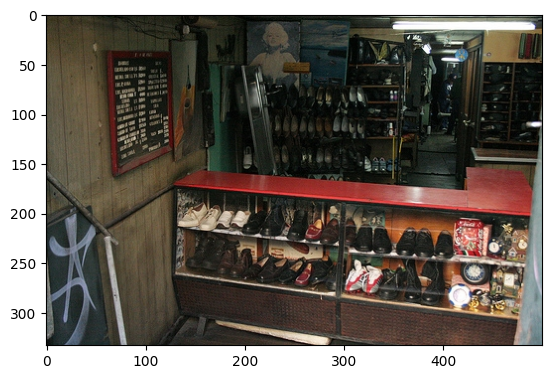

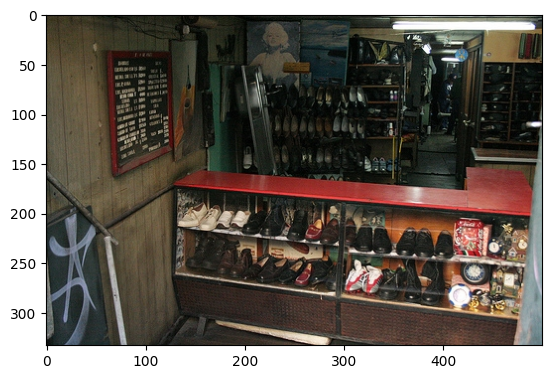

In [19]:


img = cv2.imread(r"data\mit_dataset\zapateria_24_23_flickr.jpg")
result = model(img, conf = 0.5)
result_extra = model_extra(img, conf = 0.5)
plot_res = result[0].plot()
plot_res_extra = result_extra[0].plot()
bboxes = result[0].boxes 
bboxes_extra = result_extra[0].boxes

# Merge bboxes have same class and intersect with each other
bboxes = merge_bboxes(bboxes) + merge_bboxes(bboxes_extra)

# Crop each bounding box and show it
padding = 20
for i,box in enumerate(bboxes):
    x1, y1, x2, y2 = box
    x1_expand = x1 - padding if x1 - padding > 0 else 0
    y1_expand = y1 - padding if y1 - padding > 0 else 0
    x2_expand = x2 + padding if x2 + padding < img.shape[1] else img.shape[1]
    y2_expand = y2 + padding if y2 + padding < img.shape[0] else img.shape[0]
    crop = img[int(y1_expand):int(y2_expand), int(x1_expand):int(x2_expand)]
    cv2.imwrite(f"crop_test/crop_{i}.jpg", crop)
    plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
    plt.show()
plt.imshow(cv2.cvtColor(plot_res
                        , cv2.COLOR_BGR2RGB))
plt.show()

plt.imshow(cv2.cvtColor(plot_res_extra
                        , cv2.COLOR_BGR2RGB)) 
plt.show()

In [6]:
def find_rectangle(img):
    if len(img.shape) == 2:
        thresh = img.astype(np.uint8)

    else:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret,thresh = cv2.threshold(gray,50,255,0)
    contours,hierarchy = cv2.findContours(thresh, 1, 2)
    print("Number of contours detected:", len(contours))

    for cnt in contours:
        x1,y1 = cnt[0][0]
        approx = cv2.approxPolyDP(cnt, 0.01*cv2.arcLength(cnt, True), True)
        if len(approx) == 4:
            x, y, w, h = cv2.boundingRect(cnt)
            ratio = float(w)/h
            if ratio >= 0.9 and ratio <= 1.1:
                cv2.drawContours(img, [cnt], -1, (0,255,255), 3)
                # cv2.putText(img, 'Square', (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)
            else:
                # cv2.putText(img, 'Rectangle', (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
                cv2.drawContours(img, [cnt], -1, (0,255,0), 3)

    return img

def find_edge(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    blur = cv2.GaussianBlur(gray,(5,5),0)

    edges = cv2.Canny(blur, 50, 150, apertureSize=3)

    return edges

def find_lines(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    blur = cv2.GaussianBlur(gray,(5,5),0)

    edges = cv2.Canny(blur, 50, 150, apertureSize=3)

    lines = cv2.HoughLines(edges, 1, np.pi / 180,  100)

    if lines is None:
        return gray

    for line in lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(gray, (x1, y1), (x2, y2), (0, 0, 255), 2)

    return gray

def find_binary_img_by_kmean(img):
    # Cover img to hsv
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_2d = img.reshape((-1,3))
    kmeans = KMeans(n_clusters=2).fit(img_2d)
    labels = kmeans.labels_
    cluster_img = labels.reshape(img.shape[:2])

    return cluster_img

Number of contours detected: 288
Number of contours detected: 105
109550 96110 0.877316293128876


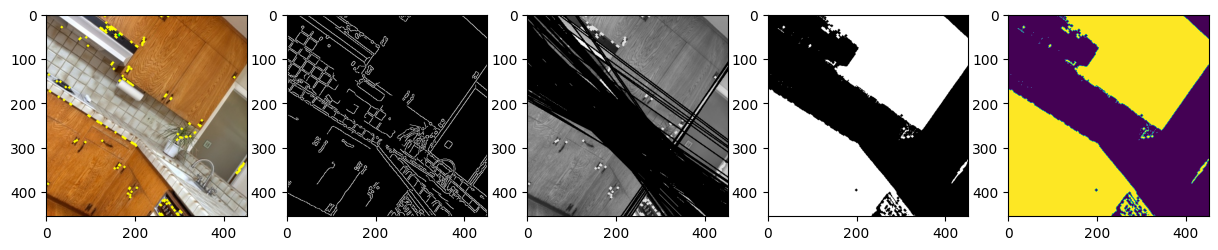

Number of contours detected: 47
Number of contours detected: 7
4478 37708 0.11875464061007045


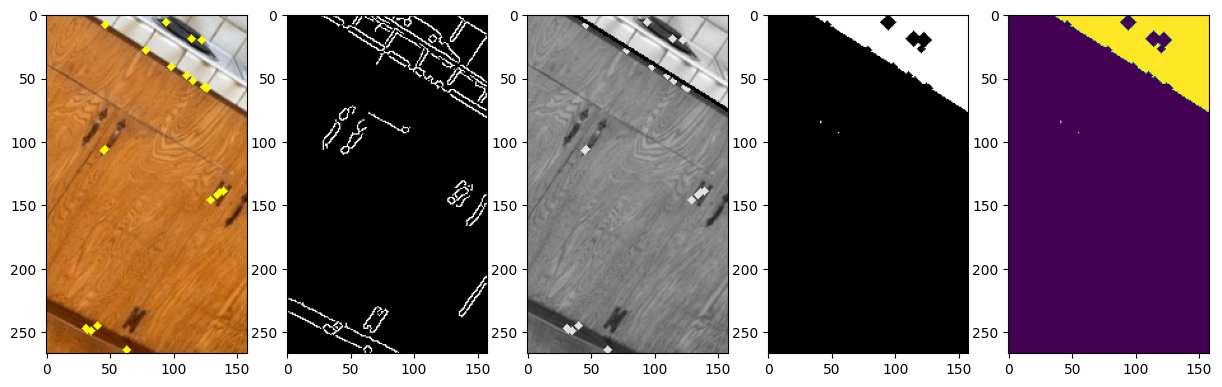

Number of contours detected: 4
Number of contours detected: 4
2 10330 0.00019361084033290573


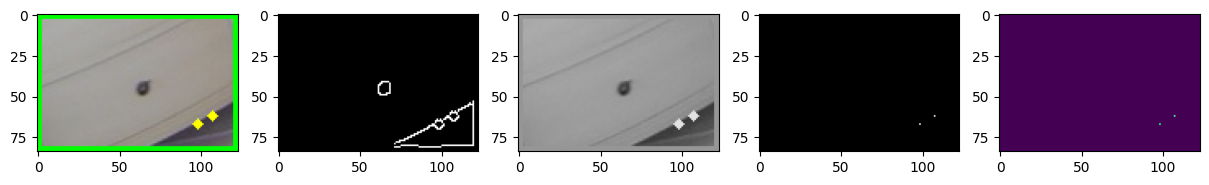

Number of contours detected: 34
Number of contours detected: 4
836 19230 0.0434737387234855


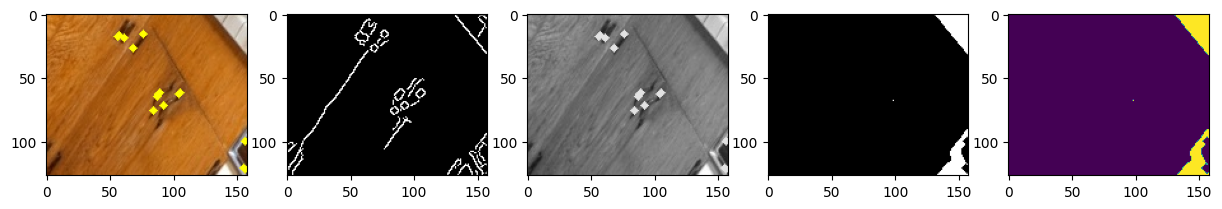

Number of contours detected: 112
Number of contours detected: 62
18512 54448 0.3399941222083564


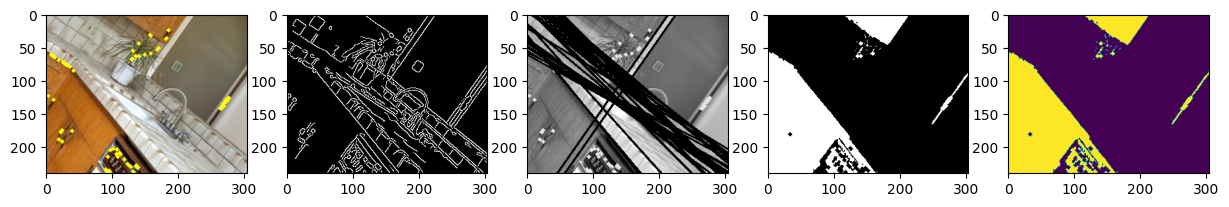

Number of contours detected: 6
Number of contours detected: 5
36 16080 0.002238805956226331


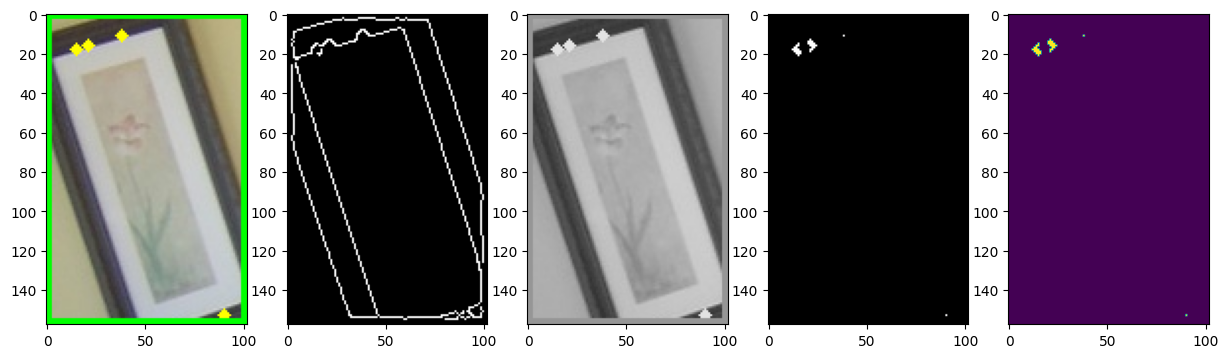

Number of contours detected: 1
Number of contours detected: 2
0 5395 0.0


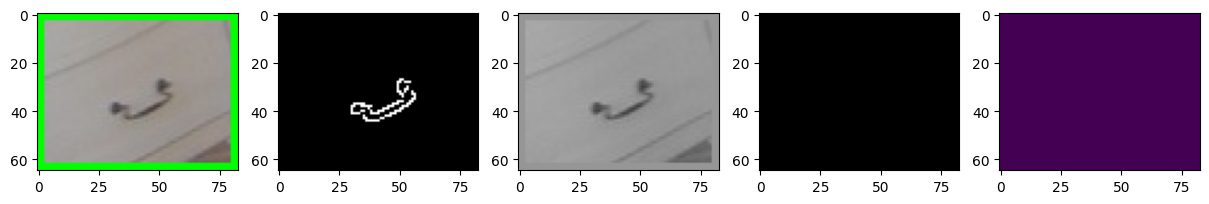

Number of contours detected: 5
Number of contours detected: 7
1581 4307 0.36707684311407374


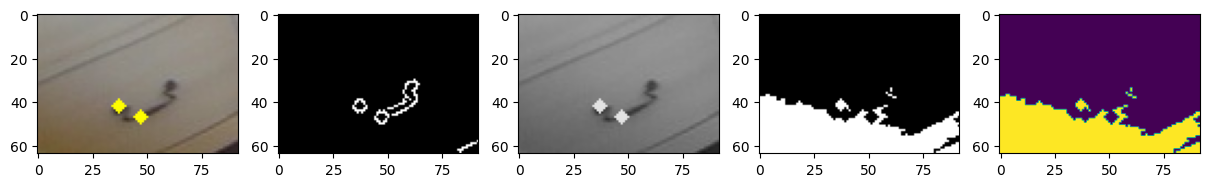

Number of contours detected: 1
Number of contours detected: 1
5307 1920 0.3617863131376236


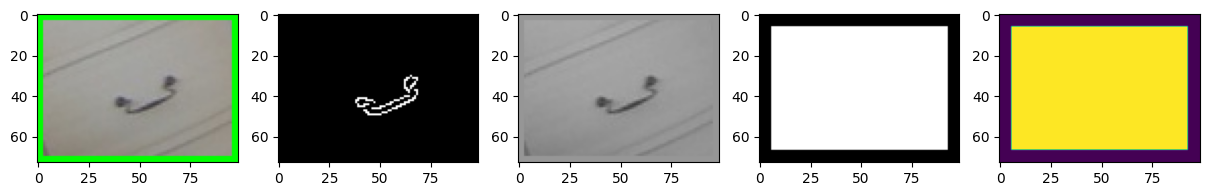

Number of contours detected: 6
Number of contours detected: 5
36 16080 0.002238805956226331


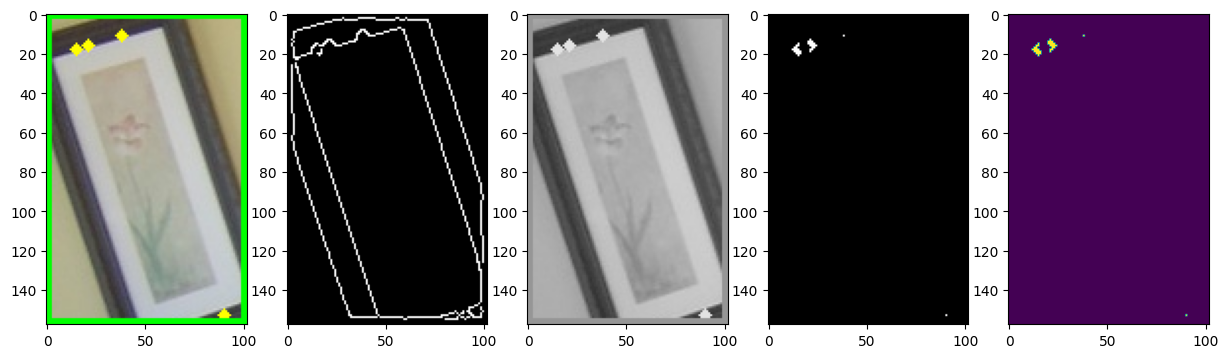

Number of contours detected: 3
Number of contours detected: 3
46 10962 0.004196314502861572


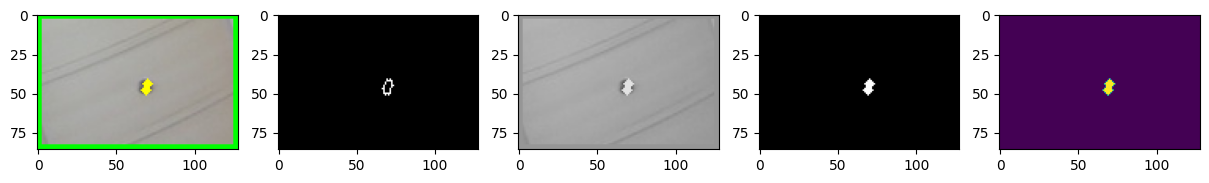

In [7]:
for img in os.listdir("crop_test"):
    img = cv2.imread(f"crop_test/{img}")
    rec = find_rectangle(img)
    edge = find_edge(img)
    line = find_lines(img)
    binary = find_binary_img_by_kmean(img)
    rec_2 = find_rectangle(binary)

    # Plot img, edge, line
    fig, ax = plt.subplots(1, 5, figsize=(15, 15))
    ax[0].imshow(cv2.cvtColor(rec, cv2.COLOR_BGR2RGB))
    ax[1].imshow(cv2.cvtColor(edge, cv2.COLOR_BGR2RGB))
    ax[2].imshow(cv2.cvtColor(line, cv2.COLOR_BGR2RGB))
    ax[3].imshow(binary, cmap='gray')
    # Calculate rate of binary
    zero_count = cv2.countNonZero(binary)
    one_count = cv2.countNonZero(1-binary)
    print(zero_count, one_count, min(zero_count/(one_count + 0.0001), one_count/(zero_count + 0.0001)))
    ax[4].imshow(rec_2)

    plt.show()